In [1]:
%load_ext autoreload
%load_ext memory_profiler
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist
settings_path = 'settings/tropics_20d.yaml'

In [3]:
## Load handler and pass settings
hdlr = handler.Handler(settings_path)

## Initiate variables
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)

## Make grid and load data on grid 
gr = grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False)

## Get ocean mask 
lm = gr.get_landmask()
ocean = lm.Landmask == 0
ocean = ocean.values[:,:,np.newaxis]

## Load storms 
st = storm_tracker.StormTracker(gr, label_var_id = "MCS_label", overwrite = False)

##
jd = joint_distrib.JointDistribution(gr, st, var_id_1 = "mean_unweighted_Prec", var_id_2 = "cond_alpha_50_Prec", nd=5, overwrite = True, dist_mask = ocean)

Data loaded from /scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /scratchx/mcarenso/tempest/DYAMOND_SAM_post_20_days_Tropics/grid_attributes.pkl instead of computing
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 5.68 seconds
Distribs have been recomputed because overwrite is set to True
Overwrite set to true, so computing basics and saving them
Time elapsed for propagating all labels: 5.83 seconds


/home/mcarenso/code/tempest/tempest/joint_distrib.py:458: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/mcarenso/code/tempest/tempest/joint_distrib.py:458: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


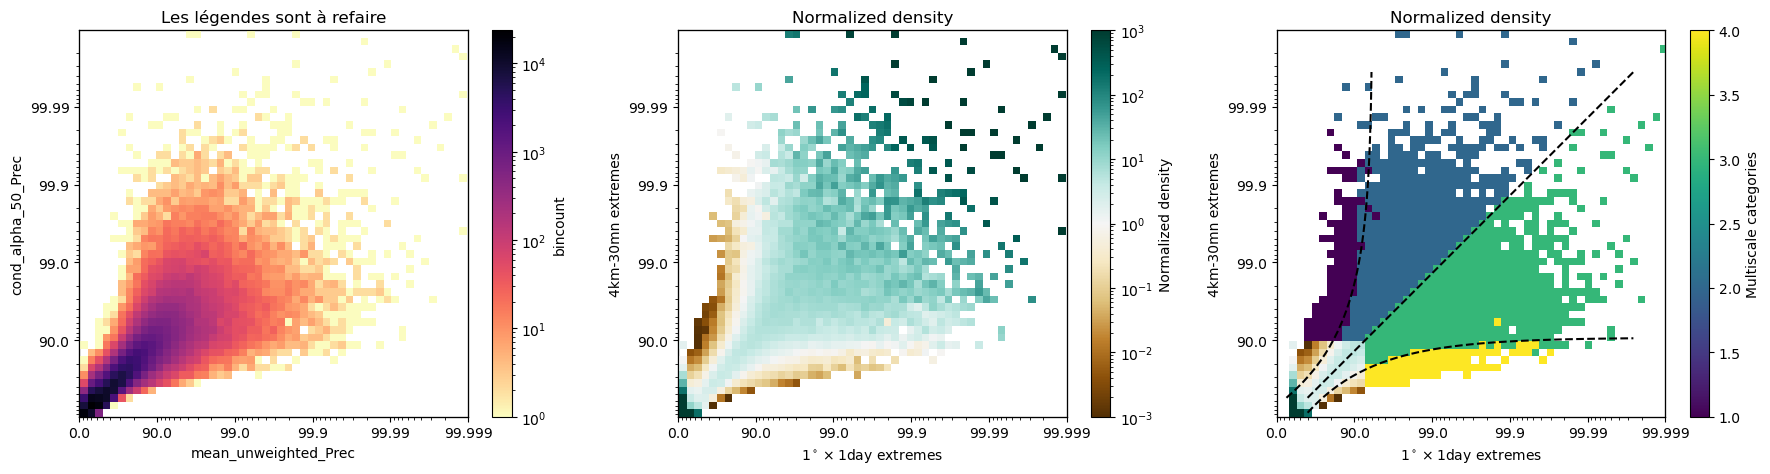

In [4]:
%matplotlib inline

fig, axs = plt.subplots(1, 3, figsize=(3.75*4.8, 4.85))

jd.plot_data(jd.bincount, scale = 'log', label = "bincount", cmap=plt.cm.magma_r , fig = fig, ax = axs[0])
axs[0].set_title("Les légendes sont à refaire")
jd.plot(mask = False, branch=False, fig = fig, ax = axs[1])
jd.plot(mask = True, branch = True, fig = fig, ax = axs[2])
plt.tight_layout()

Convective only
figure size = 15 3.25
Mostly convective
figure size = 15 3.25
Mostly mesoscale
figure size = 15 3.25
Mesoscale only
figure size = 15 3.25


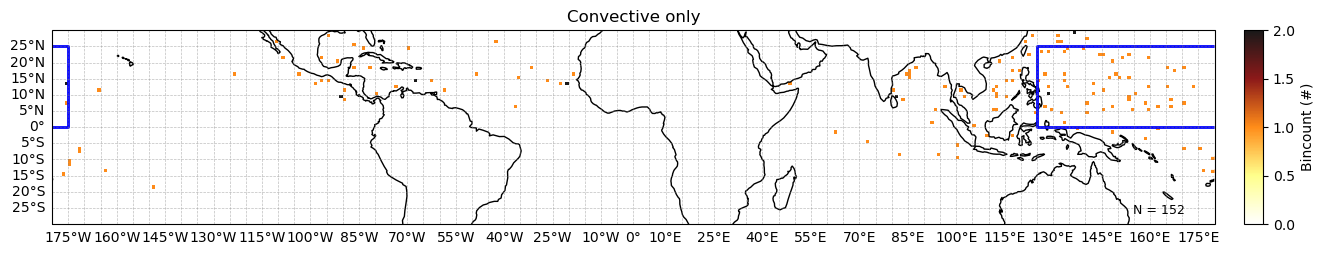

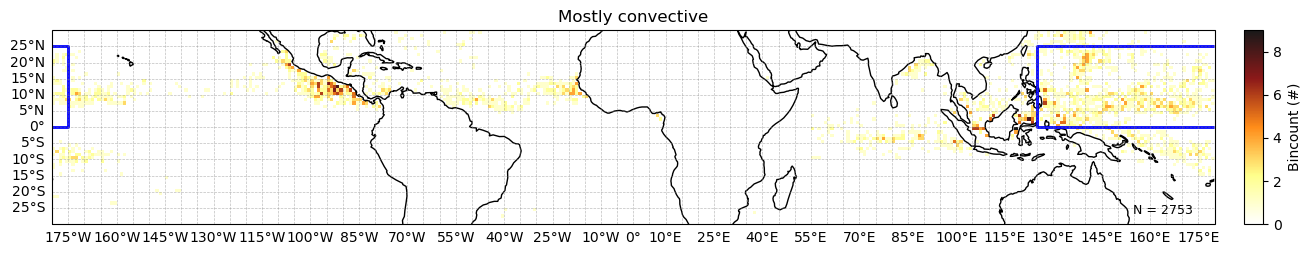

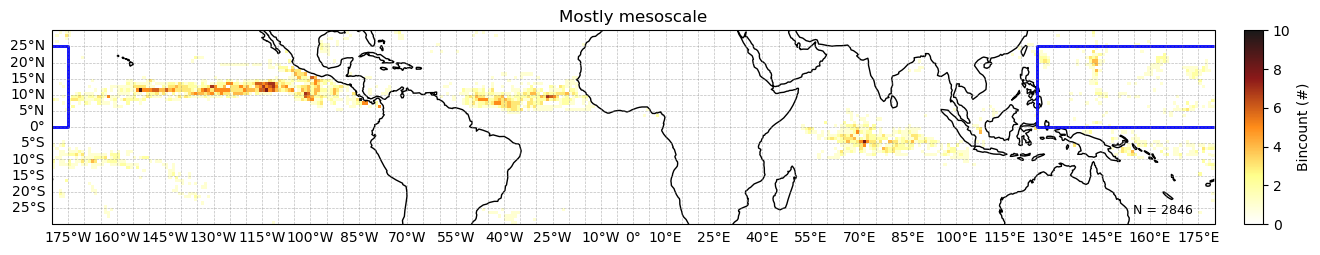

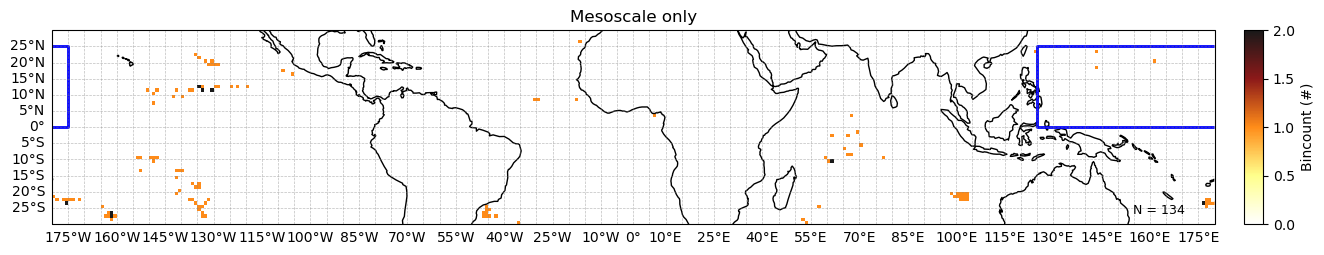

In [30]:
import cartopy.crs as ccrs
import os 
%matplotlib inline
# Show frequency maps of extremes in the 4 regions (normalized by total bincount in mask?)

jd.make_mask()

mask_all = [jd.mask_branch1_90, jd.mask_coloc_c_90, jd.mask_coloc_ac_90, jd.mask_branch2_90]
mask_names = 'Convective only','Mostly convective','Mostly mesoscale','Mesoscale only'
mask_labels = 'conv','mostlyconv','mostlyacc','acc'
figdir = ''

# rank  = 2 # 2 , 3,4

# if rank == 1 : 
#     rank_min, rank_max = 90, 99
# elif rank == 2 :
#     rank_min, rank_max = 99, 99.9
# elif rank == 3 :
#     rank_min, rank_max = 99.9, 99.99
# elif rank == 4 :
#     rank_min, rank_max = 99.99, 100

rank_conv_min = 99
rank_acc_min = 99

mask_rank_conv = np.outer(jd.dist1.ranks >= 0, jd.dist2.ranks >= rank_conv_min)
mask_rank_acc = np.outer(jd.dist1.ranks >= rank_acc_min , jd.dist2.ranks >= 0)
            
mask_rank_all = [mask_rank_conv, mask_rank_conv, mask_rank_acc, mask_rank_acc]

for mask,mask_rank, mask_name,mask_label in zip(mask_all,mask_rank_all,mask_names,mask_labels):
    
    print(mask_name)
    mask_ranked = np.logical_and(mask, mask_rank)
    mask_yxt = jd.get_mask_yxt_from_mask_jdist(mask_ranked)
    mask_yxt_ocean = np.logical_and(mask_yxt, ocean)
    ax = jd.make_map(mask_yxt_ocean, data = None)

    # lon_min, lon_max = 215, 280 #gr.lon_slice.start , gr.lon_slice.stop
    # lat_min, lat_max = 5, 20#gr.lat_slice.start, gr.lat_slice.stop
    # ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
    #             [lat_min, lat_min, lat_max, lat_max, lat_min],
    #             color='red', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Eastern Pacific ITCZ")
    lon_min, lon_max = 125, 185 #gr.lon_slice.start , gr.lon_slice.stop
    lat_min, lat_max = 0, 25#gr.lat_slice.start, gr.lat_slice.stop
    ax.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                [lat_min, lat_min, lat_max, lat_max, lat_min],
                color='blue', linestyle='-', linewidth=2, transform=ccrs.PlateCarree(), label = "Pacific Warmpool")
    
    # ax.legend()
    
    ax.set_title(mask_name)

    # plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')
    # plt.savefig(os.path.join(figdir,'map_bincount_%s_extremes.png'%(mask_label)),bbox_inches='tight')

## Threshld and sigma on map - various ways

figure size = 15 3.25
figure size = 15 3.25


<GeoAxesSubplot:xlabel='Longitude', ylabel='Latitude'>

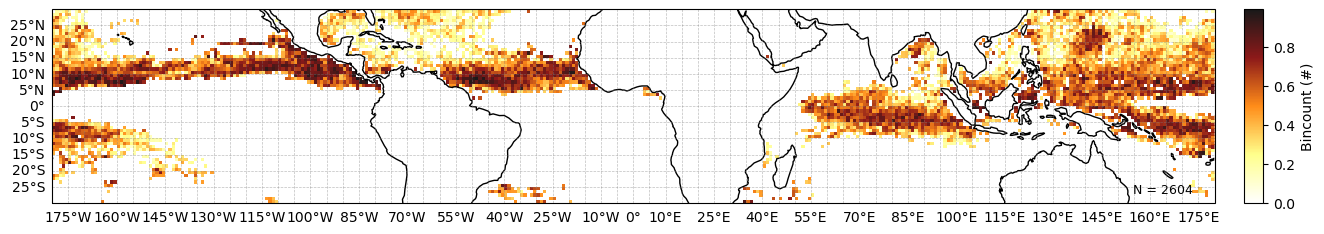

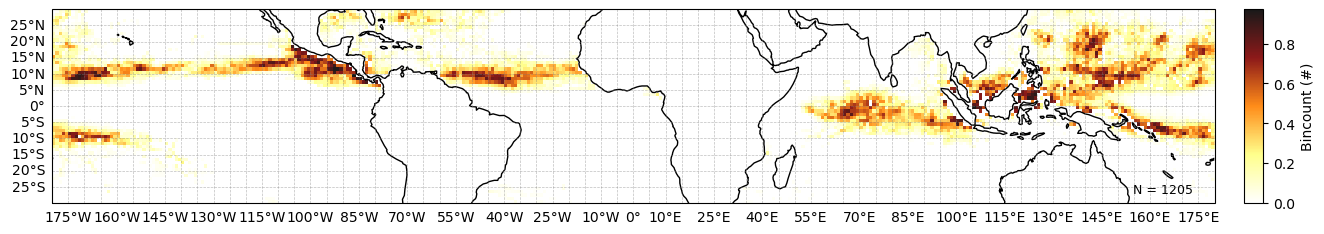

In [72]:
# km-scale map threshsold 
rank_min = 90
data = jd.prec.Treshold_cond_alpha_50_Prec.values

mask_rank = np.outer(jd.dist1.ranks >= rank_min, jd.dist2.ranks >= rank_min)

mask_yxt_all = jd.get_mask_yxt_from_mask_jdist(mask_rank)
mask_ocean_all = np.logical_and(mask_yxt_all, ocean)

jd.make_map(mask_ocean_all, data = data, func = "data_weighted")

# coarse-grained map sigma
rank_min = 90
data = jd.prec.Sigma_cond_alpha_50_Prec.values

mask_rank = np.outer(jd.dist1.ranks >= rank_min, jd.dist2.ranks >= rank_min)

mask_yxt_all = jd.get_mask_yxt_from_mask_jdist(mask_rank)
mask_ocean_all = np.logical_and(mask_yxt_all, ocean)

jd.make_map(mask_ocean_all, data = data, func = "data_weighted")

figure size = 15 3.25
figure size = 15 3.25


<GeoAxesSubplot:xlabel='Longitude', ylabel='Latitude'>

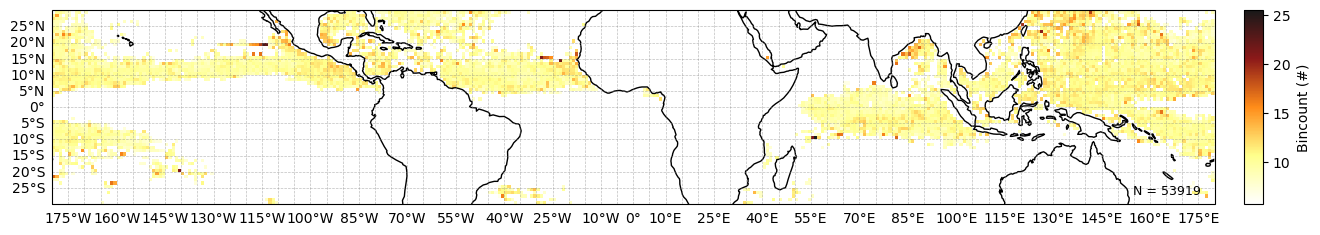

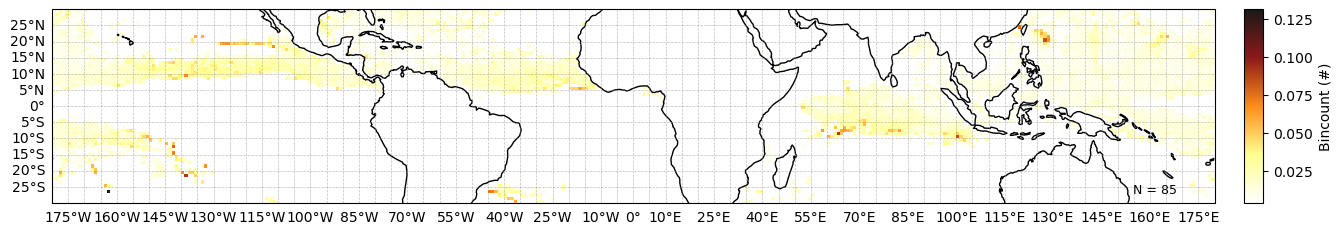

In [78]:
# km-scale map threshsold 
rank_min = 90
data = jd.prec.Treshold_cond_alpha_50_Prec.values

mask_rank = np.outer(jd.dist1.ranks >= rank_min, jd.dist2.ranks >= rank_min)

mask_yxt_all = jd.get_mask_yxt_from_mask_jdist(mask_rank)
mask_ocean_all = np.logical_and(mask_yxt_all, ocean)

jd.make_map(data, data = mask_ocean_all, func = 'data_weighted')

# coarse-grained map sigma
rank_min = 90
data = jd.prec.Sigma_cond_alpha_50_Prec.values

mask_rank = np.outer(jd.dist1.ranks >= rank_min, jd.dist2.ranks >= rank_min)

mask_yxt_all = jd.get_mask_yxt_from_mask_jdist(mask_rank)
mask_ocean_all = np.logical_and(mask_yxt_all, ocean)

jd.make_map(data, data =mask_ocean_all, func = 'data_weighted')

figure size = 15 3.25
figure size = 15 3.25


<GeoAxesSubplot:xlabel='Longitude', ylabel='Latitude'>

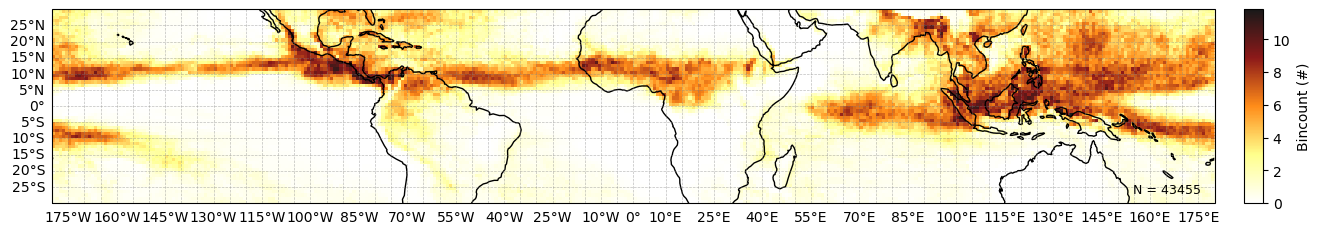

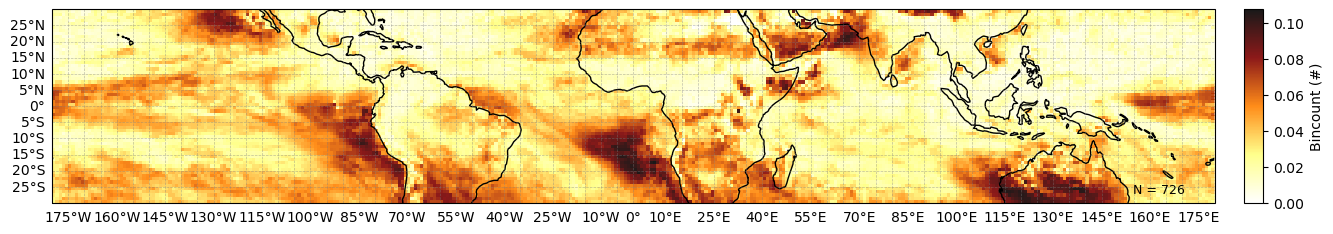

In [77]:
# km-scale map threshsold 
data = jd.prec.Treshold_cond_alpha_50_Prec.values
jd.make_map(data/20, data = None)

# coarse-grained map sigma
data = jd.prec.Sigma_cond_alpha_50_Prec.values
jd.make_map(data/20, data = None)

## Propagate p_alpha and \sigma_alpha by making a count weighted by their values

## Func that makes region mask

In [88]:
def make_region_mask(min_lat, max_lat, min_lon, max_lon, pre_mask = True):
    array_shape = (60, 360, 20)
    # Combine the masks along each dimension
    mask = np.zeros(array_shape, dtype=bool)
    mask[min_lat+30:max_lat+30, min_lon:max_lon, :] = True
    mask = np.logical_and(mask, pre_mask)
    return mask

warmpool = make_region_mask(0, 25, 125, 185, pre_mask = ocean)
indian_ocean = make_region_mask(-15, 10, 50, 100, pre_mask = ocean)

## Storms attributes

/home/mcarenso/code/tempest/tempest/joint_distrib.py:731: RuntimeWarning: invalid value encountered in scalar divide
  bin_fraction_mcs[i_bin,j_bin] = count_bin_mcs/count_bin


(<AxesSubplot:xlabel='mean_unweighted_Prec', ylabel='cond_alpha_50_Prec'>,
 <matplotlib.colorbar.Colorbar at 0x14aed3a4be50>)

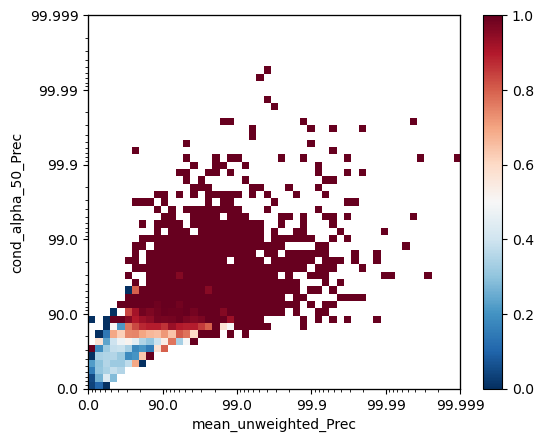

In [7]:
data, noise, count = jd.get_mcs_bin_fraction(region_mask = indian_ocean, bin_noise_treshold= 0)
jd.plot_data(data, noise, vbds = (0,1))

## test day variability

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495001234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849500123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495001234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849500123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495001234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849500123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495001234567891011121314151617181920212223242526272829303132333435363738394041424344

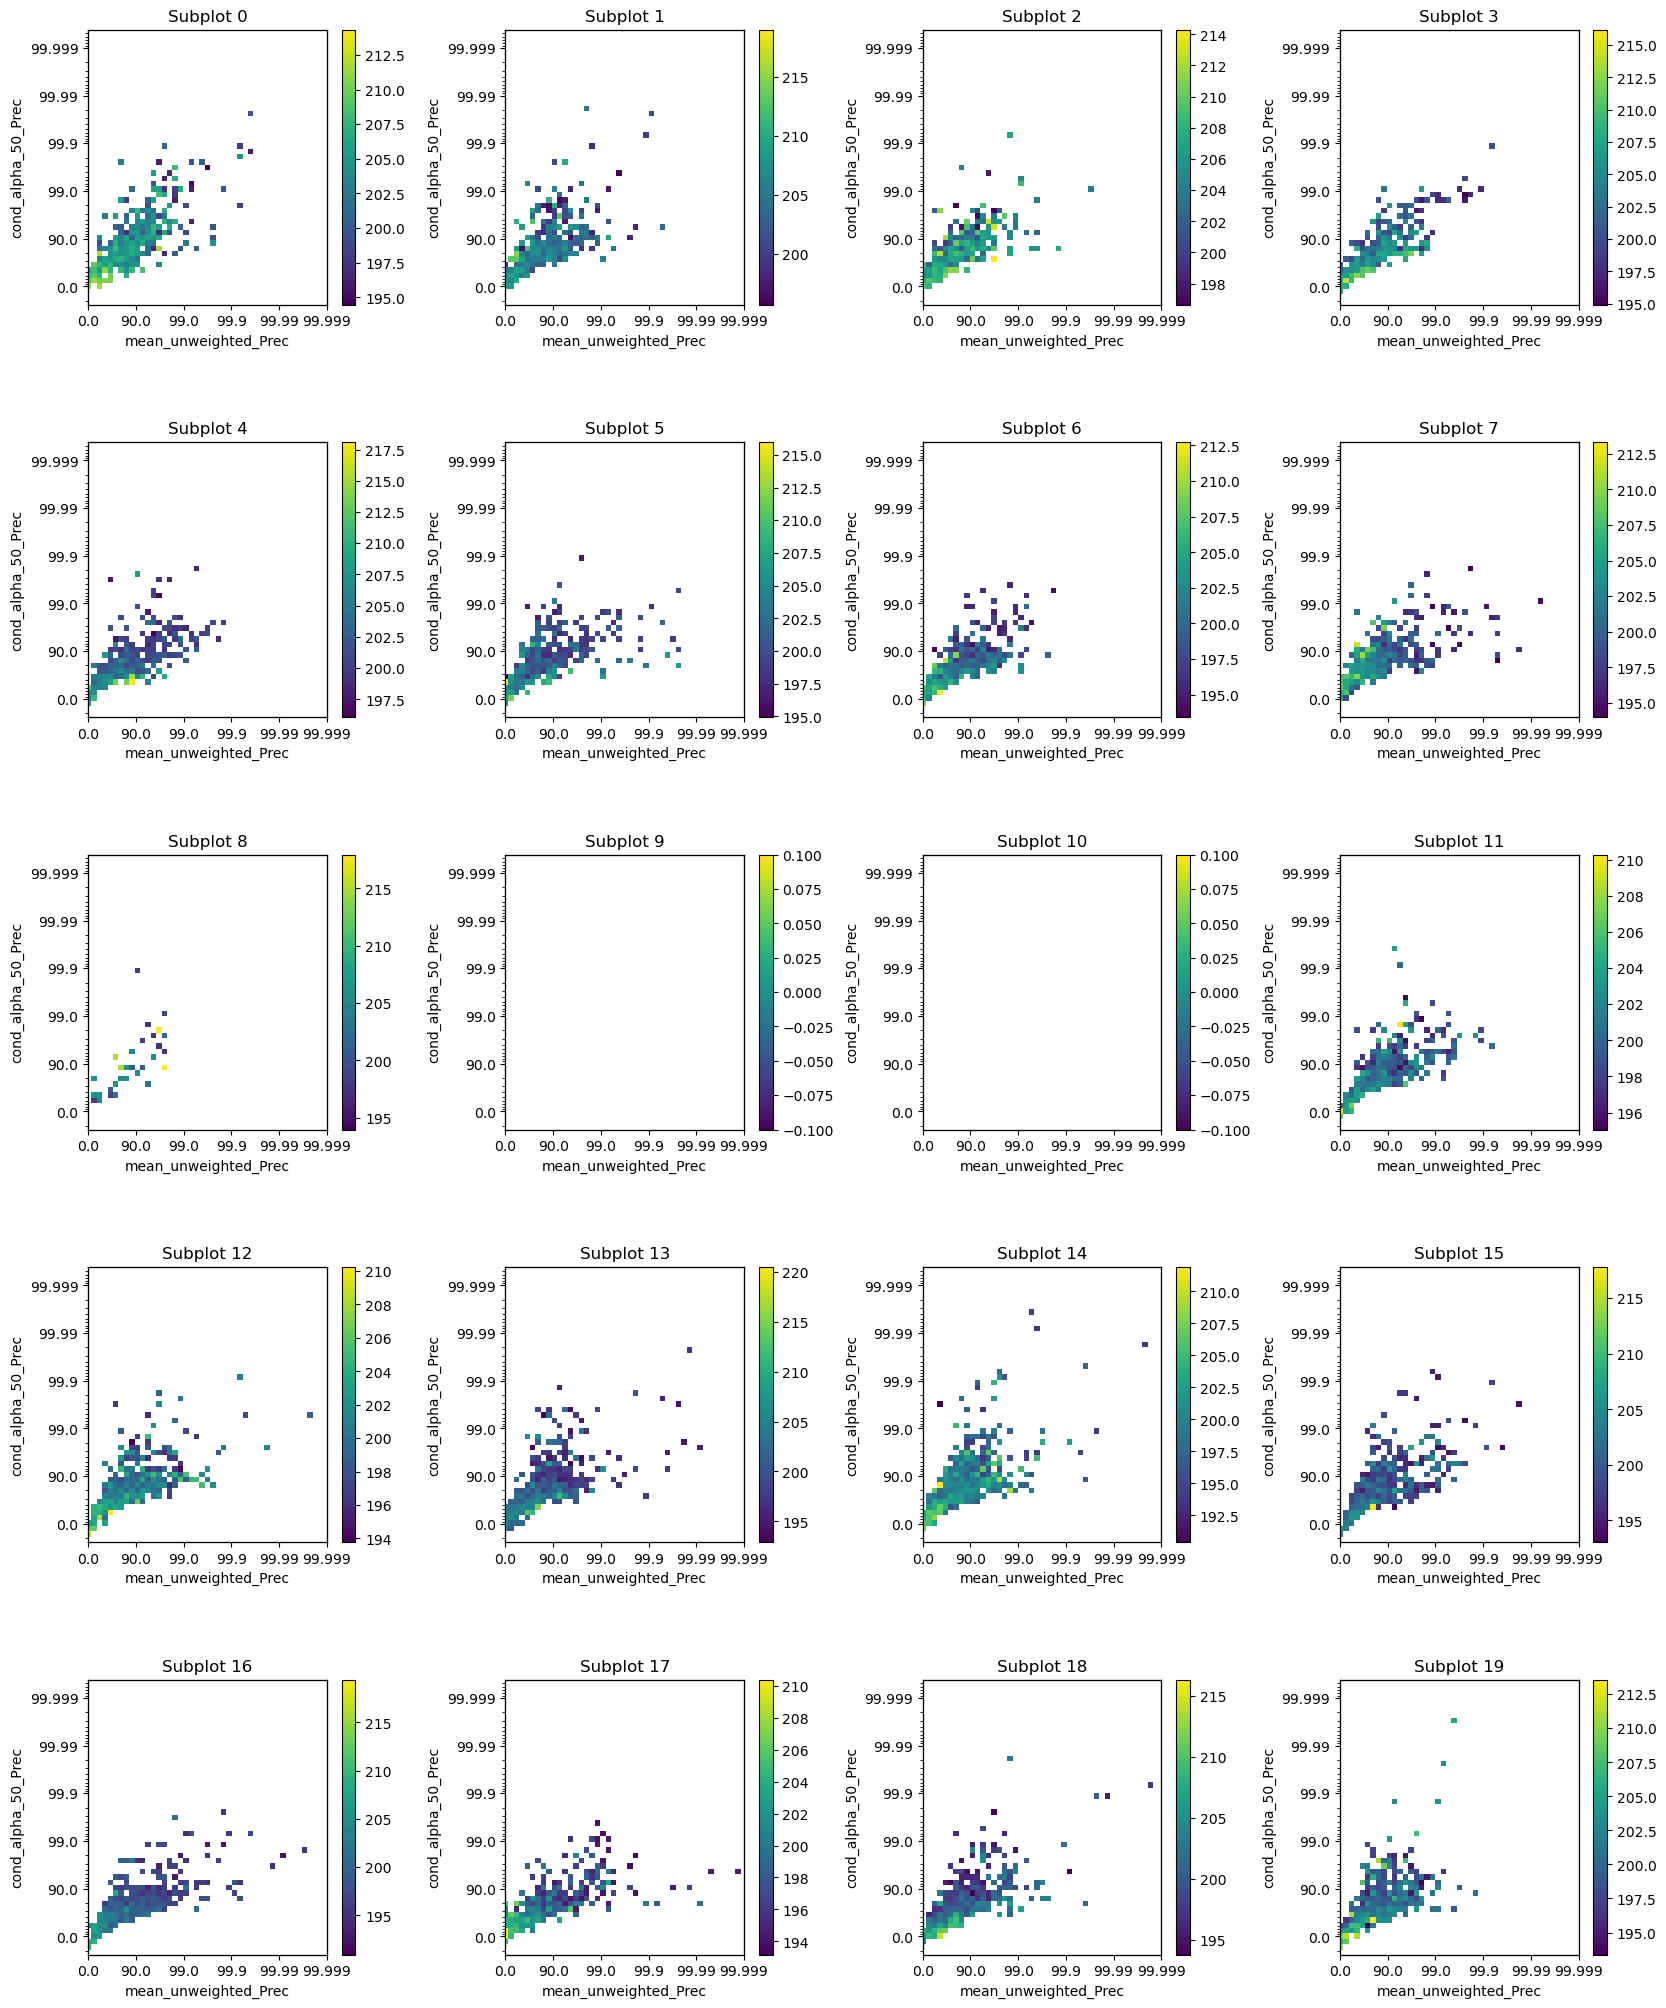

<Figure size 640x480 with 0 Axes>

In [15]:
# Create a 5x4 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 25))
fig.subplots_adjust(hspace=0.5, wspace=0.4)

for i, ax in enumerate(axes.flatten()):
    # Copy the original mask to avoid modifying it directly
    modified_mask = np.copy(indian_ocean)

    num_days = modified_mask.shape[2]

    days_mask = np.zeros(num_days, dtype = bool)
    days_mask[i] = True
    # Set the ith slice to False
    modified_mask[:, :, ~days_mask] = False

    # Generate the storm attribute data using the modified mask
    # This is a conceptual call, replace it with the actual function call you have
    storm_var = jd.storm_attributes_on_jdist('min_olr_90th', np.mean, fast=False, region_mask=modified_mask)

    # Plot the data on the current subplot
    ax, cb = jd.plot_data(storm_var, cmap = 'viridis', fig = fig, ax = ax, cb_bool = True)
    ax.set_title(f'Subplot {i}')
    
plt.show()
plt.tight_layout()

## avg, Min OLR_90th 

01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950

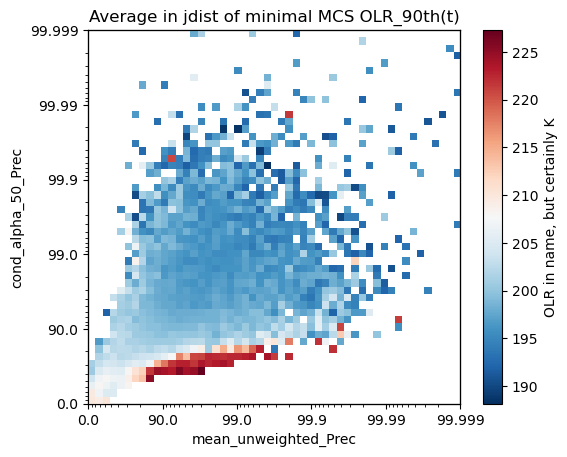

In [81]:
%matplotlib inline
def percentile_90(numbers):
    return np.percentile(numbers, 90)
storm_var = jd.storm_attributes_on_jdist('min_olr_90th', np.mean, fast = False, region_mask = ocean)
ax, cb = jd.plot_data(storm_var,  vbds = (None, None))

ax.set_title('Average in jdist of minimal MCS OLR_90th(t)')
cb.set_label("OLR in name, but certainly K")

01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950

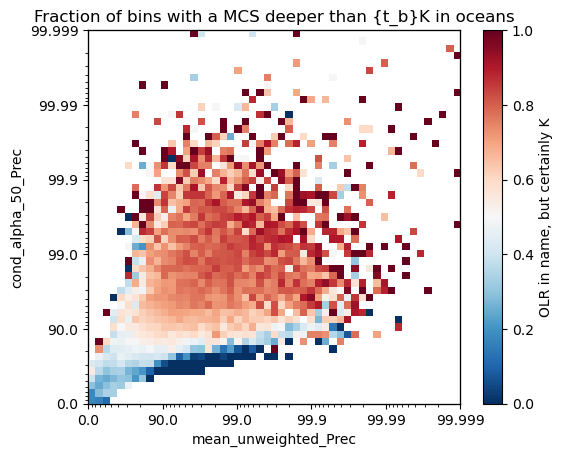

In [85]:
%matplotlib inline
def frac_under_threshold(numbers, threshold):
    return np.sum(numbers < threshold)/len(numbers)

t_b = 200
storm_var = jd.storm_attributes_on_jdist('min_olr_90th', lambda x: frac_under_threshold(x, t_b) , fast = False, region_mask = ocean)
ax, cb = jd.plot_data(storm_var,  vbds = (None, None))

ax.set_title('Fraction of bins with a MCS deeper than {t_b}K in oceans')
cb.set_label("OLR in name, but certainly K")

01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950

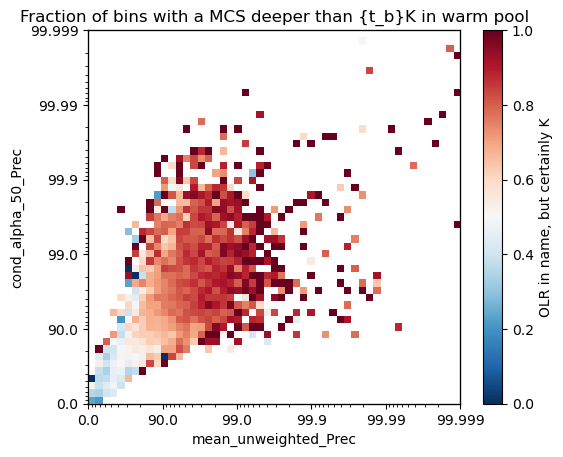

In [89]:
%matplotlib inline
def frac_under_threshold(numbers, threshold):
    return np.sum(numbers < threshold)/len(numbers)

t_b = 200
storm_var = jd.storm_attributes_on_jdist('min_olr_90th', lambda x: frac_under_threshold(x, t_b) , fast = False, region_mask = warmpool)
ax, cb = jd.plot_data(storm_var,  vbds = (None, None))

ax.set_title('Fraction of bins with a MCS deeper than {t_b}K in warm pool')
cb.set_label("OLR in name, but certainly K")

01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950

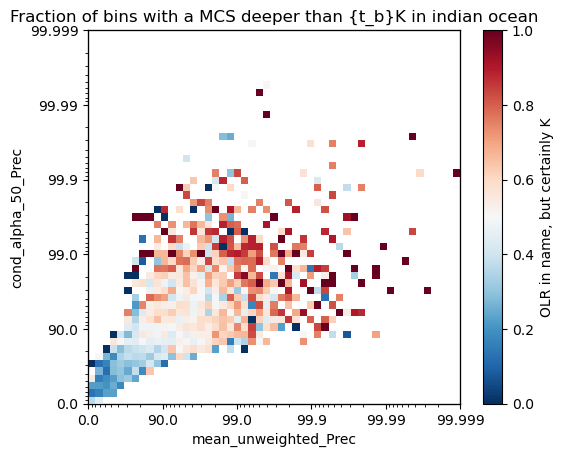

In [91]:
%matplotlib inline
def frac_under_threshold(numbers, threshold):
    return np.sum(numbers < threshold)/len(numbers)

t_b = 200
storm_var = jd.storm_attributes_on_jdist('min_olr_90th', lambda x: frac_under_threshold(x, t_b) , fast = False, region_mask = indian_ocean)
ax, cb = jd.plot_data(storm_var,  vbds = (None, None))

ax.set_title('Fraction of bins with a MCS deeper than {t_b}K in indian ocean')
cb.set_label("OLR in name, but certainly K")

## Made some new attributes for storms here TODO : put it in ds_storms overwirte = True compartiment

In [ ]:
storms = xr.open_dataset(jd.file_storms, mode='r')
storms["min_olr_90th"] = storms.olr_90th.min(dim = 'time', skipna = True)

In [ ]:
os.remove(jd.file_storms)
storms.to_netcdf(jd.file_storms)
storms.close()